In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from datetime import date
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# read the dataset
df = pd.read_excel('Data_forecast_covid2021.xlsx')

In [3]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

In [4]:
df.Timestamp = pd.to_datetime(df.Tanggal, unit='Y')

C:\Users\HP\AppData\Local\Temp\ipykernel_7704\2680437410.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Timestamp = pd.to_datetime(df.Tanggal, unit='Y')


In [5]:
df.index = df.Tanggal
df.head()

,Tanggal,ID_KEC,Nama_provinsi,nama_kota,nama_kecamatan,POSITIF
Tanggal,,,,,,
2021-01-01,2021-01-01,317506,DKI JAKARTA,JAKARTA TIMUR,CAKUNG,5131
2021-01-01,2021-01-01,317105,DKI JAKARTA,JAKARTA PUSAT,CEMPAKA PUTIH,2294
2021-01-01,2021-01-01,317301,DKI JAKARTA,JAKARTA BARAT,CENGKARENG,5837
2021-01-01,2021-01-01,317406,DKI JAKARTA,JAKARTA SELATAN,CILANDAK,3173
2021-01-01,2021-01-01,317204,DKI JAKARTA,JAKARTA UTARA,CILINCING,3761


#  Resample to daily period

In [6]:
df_day = df.resample('D').mean()
missing_replacement = df['2021-01-25': '2021-01-28'].mean(numeric_only=True)
df_day.loc['2021-01-26'] = missing_replacement
df_day.loc['2021-01-27'] = missing_replacement
df_day.loc['2021-01-28'] = missing_replacement

df_day.isnull().sum()

POSITIF    0
dtype: int64

# Timeseries Visualization

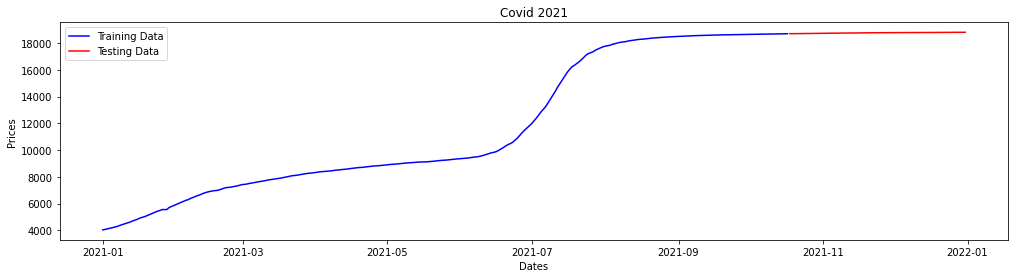

In [7]:
df_train = df_day.loc['2021-01-01':'2021-10-17']
df_test = df_day.loc['2021-10-18':]

plt.figure(figsize=(17, 4))
plt.title('Covid 2021')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train.POSITIF, 'blue', label='Training Data')
plt.plot(df_test.POSITIF, 'red', label='Testing Data')

plt.legend()

y_train = df_train.POSITIF.values
y_test = df_test.POSITIF.values

In [8]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print('Estimated differencing term:', n_diffs)

auto = pm.auto_arima(
    y_train, d=n_diffs, 
    seasonal=True, stepwise=True,
    suppress_warnings=True, error_action="ignore", 
    max_p=6, max_order=None, trace=True
)

Estimated differencing term: 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2525.929, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3225.507, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2539.120, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2943.719, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3365.379, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2524.669, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2797.858, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2532.433, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2525.748, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2743.506, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2529.336, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2513.005, Time=0.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2523.834, Time=0.79 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2514.685, Time=0.64 sec
 A

# Model Evaluation 

In [9]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

y_predict = []
y_confidence = []

for i, new_ob in enumerate(y_test):
    fc, conf = forecast_one_step()
    y_predict.append(fc)
    y_confidence.append(conf)
    
    print(i, fc, new_ob, abs(fc - new_ob))

    model.update(new_ob)

print('Mean squared error:', mean_squared_error(y_test, y_predict, squared=False))
print('Root Mean squared error:', mean_squared_error(y_test, y_predict))
print('R-Squared', r2_score(y_test, y_predict))

0 18704.471186882485 18701.130434782608 3.340752099877136
1 18706.442706484842 18703.434782608696 3.0079238761463785
2 18708.674431950254 18705.67391304348 3.000518906774232
3 18710.7196168526 18707.608695652172 3.1109212004266737
4 18712.388255060523 18709.41304347826 2.9752115822630003
5 18714.00147020164 18711.934782608696 2.0666875929455273
6 18716.96507757022 18714.782608695652 2.1824688745691674
7 18719.892572986493 18716.565217391304 3.3273555951891467
8 18720.983863110236 18717.369565217392 3.6142978928437515
9 18721.196627924175 18719.652173913044 1.5444540111311653
10 18724.458895827214 18722.5 1.9588958272142918
11 18727.373289075225 18724.58695652174 2.7863325534854084
12 18729.112585699364 18726.67391304348 2.4386726558841474
13 18731.327328849322 18729.130434782608 2.1968940667138668
14 18733.97004418171 18730.934782608696 3.0352615730153047
15 18735.29070698009 18732.608695652172 2.68201132791728
16 18736.984035075293 18735.478260869564 1.5057742057288124
17 18740.605625

# Visualize the prediction values

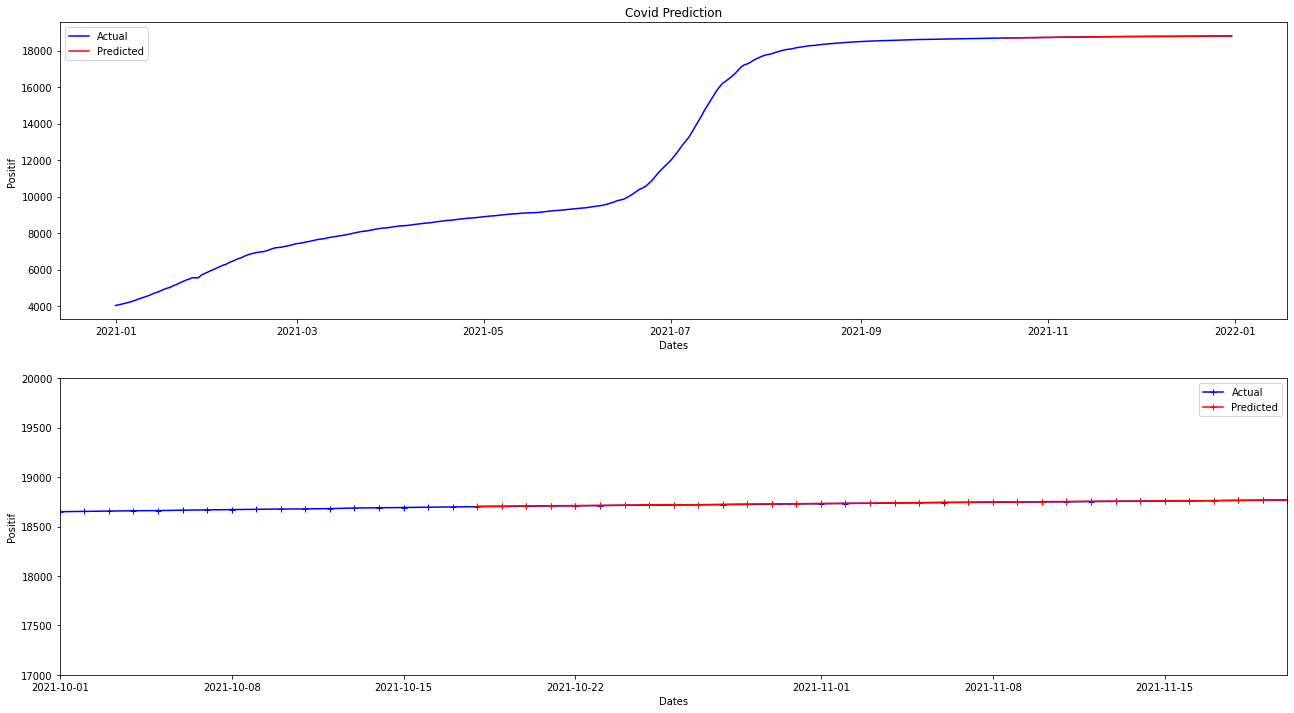

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(22, 12))

axes[0].plot(df_day.index, df_day.POSITIF, color='blue', label='Actual')
axes[0].plot(df_test.index, y_predict, color='red', label='Predicted')

axes[0].set_title('Covid Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Positif')
axes[0].legend()

axes[1].plot(df_day.index, df_day.POSITIF, ls='-', marker='+', color='blue', label='Actual')
axes[1].plot(df_test.index, y_predict, ls='-', marker='+', color='red', label='Predicted')

axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Positif')
axes[1].set_xlim(date(2021, 10, 1), date(2021, 11, 20))
axes[1].set_ylim(17000, 20000)
axes[1].legend()

plt.savefig('ARIMACov2021.jpg',  dpi=300, bbox_inches='tight')
plt.show()